In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from IPython.display import clear_output
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import io 
import json

In [2]:
class Vectorizer():
    def __init__(self, corp_path):
        self.corp_path = corp_path
    
    def upload_corp(self):
        with open(self.corp_path, 'r',encoding = 'utf-8') as f:
            self.corp = list(set(f.read().split('\n')[:-1]))
        self.corp = [text.replace('$$$', ' ') for text in self.corp]
    
    
    def log(self, part):
        clear_output(wait=True)
        print(f'{part} is processing')
        
    def make_tf_idf_matrix(self, token_pattern=None, min_df = 1, max_df=None, use_idf = True):
        if token_pattern:
            self.tfidf = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            self.tfidf = TfidfVectorizer(analyzer='word', min_df=min_df, use_idf=use_idf)
            
        self.W = self.tfidf.fit_transform(self.corp)
        self.words_list = self.tfidf.get_feature_names_out()
        
    def make_svd(self, output_folder, k=30 ):
#         self.u, self.sigma, self.vt = svds(self.W, k)
        
#         self.descending_order_of_inds = np.flip(np.argsort(self.sigma))
#         self.u = self.u[:,self.descending_order_of_inds]
#         self.vt = self.vt[self.descending_order_of_inds,:]
#         self.sigma = np.diag(self.sigma[self.descending_order_of_inds])
        self.u, self.sigma, self.vT = svds(self.W, k)
        self.descending_order_of_inds = np.argsort(-self.sigma)
        
        self.u = self.u[:, self.descending_order_of_inds]
        self.sigma = np.diag(self.sigma[self.descending_order_of_inds])
        self.vT = self.vT[self.descending_order_of_inds, :]

        #Checking that sizes are ok
        #assert self.sigma.shape == (k,)
        #assert swlf.vt.shape == (k, self.W.shape[1])
        #assert swlf.u.shape == (self.W.shape[0], k)
        print (self.W.shape)
        print (self.sigma.shape)
        print (self.vT.shape)
        print (self.u.shape)
        
        self.embedded_matrix = self.sigma@self.vT
        #self.embedded_matrix = np.dot(np.diag(self.sigma), self.vt).T
        self.words_embedding_dict = dict(zip(self.words_list, self.embedded_matrix.T))
        #self.words_embedding_dict = dict(zip(self.words_list, self.embedded_matrix))
        
        with open(output_folder+'/' + str(k) + '_sigma_vt.npy', 'wb') as f:
            #np.save(f, np.dot(np.diag(self.sigma), self.vt).T)
            np.save(f, self.embedded_matrix.T)
        with open(output_folder+'/' +  str(k) + '_sigma.npy', 'wb') as f:
            np.save(f, self.sigma)
        with open(output_folder+'/' +  str(k) + '_u.npy', 'wb') as f:
            np.save(f, self.u)
        with open(output_folder+'/' +  str(k) + '_vt.npy', 'wb') as f:
            np.save(f, self.vT)
            
        self.save_word_embedding(k)
    
    
    def save_word_embedding(self, shape):
        
        dict_ = {}
        for key, value in self.words_embedding_dict.items():
            dict_[key] = value.tolist()
        save_name = "Thai_WordVectorDict_SVD" + str(shape) + ".json"
        with open(save_name, 'w') as f:
            json.dump(dict_, f)
            
    def get_emb_dict(self):
        
        self.log('Upload')
        self.upload_corp()
        self.log('TfIdf')
        self.make_tf_idf_matrix()
        self.log('SVD')
        self.make_svd('./Matrixes',k=100)
        
        return self.words_embedding_dict

In [3]:
vect = Vectorizer('./Thai_corpus.txt')
emb_dict = vect.get_emb_dict()

SVD is processing
(5781, 8985590)
(100, 100)
(100, 8985590)
(5781, 100)


In [42]:
for c, k in enumerate(emb_dict.keys()):
    print(f'{k}: ', emb_dict[k].round(4))
    if c == 10:
        break



ขข:  [-0.1028 -0.1266  0.0271 -0.0155 -0.0188 -0.008   0.0596 -0.0367  0.033
 -0.0102  0.0045  0.0123  0.0163  0.0205  0.0324  0.0154  0.0128  0.0364
  0.0008  0.0155  0.014  -0.0013 -0.0404  0.0004  0.004  -0.0164  0.0578
 -0.0304  0.0792  0.0079 -0.0028 -0.0591  0.0465 -0.02   -0.0112 -0.0552
 -0.0073  0.0393 -0.0094 -0.0078 -0.0046 -0.0996 -0.0101  0.0779 -0.0298
 -0.0206  0.0095  0.1176 -0.0542  0.0153  0.0386 -0.0311 -0.0017 -0.0073
 -0.0308  0.0698 -0.0735  0.0069  0.0083  0.0197  0.0377 -0.0107 -0.0247
  0.085  -0.0472 -0.069  -0.0023  0.1123  0.0913 -0.0206 -0.0168 -0.0372
  0.0503  0.0352  0.014   0.0415 -0.0568 -0.0115  0.1167 -0.0207 -0.0401
 -0.0995 -0.0929 -0.0529 -0.0555  0.0201  0.0009 -0.0718  0.1089 -0.0258
  0.0334 -0.0309  0.0473  0.1197 -0.0259  0.0016  0.0371 -0.0459  0.0187
 -0.0554]
ขขข:  [-0.0174 -0.0305  0.0104 -0.0116 -0.0083 -0.0013  0.0112 -0.0076  0.0043
 -0.0019  0.0018 -0.0009  0.0047  0.0055  0.0073  0.0013  0.0005  0.0079
  0.0021  0.0031  0.0024 -0.001

[[37.26959965  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         11.09814606  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          8.66776927 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  2.02538275  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          2.01846703
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   2.01398455]]


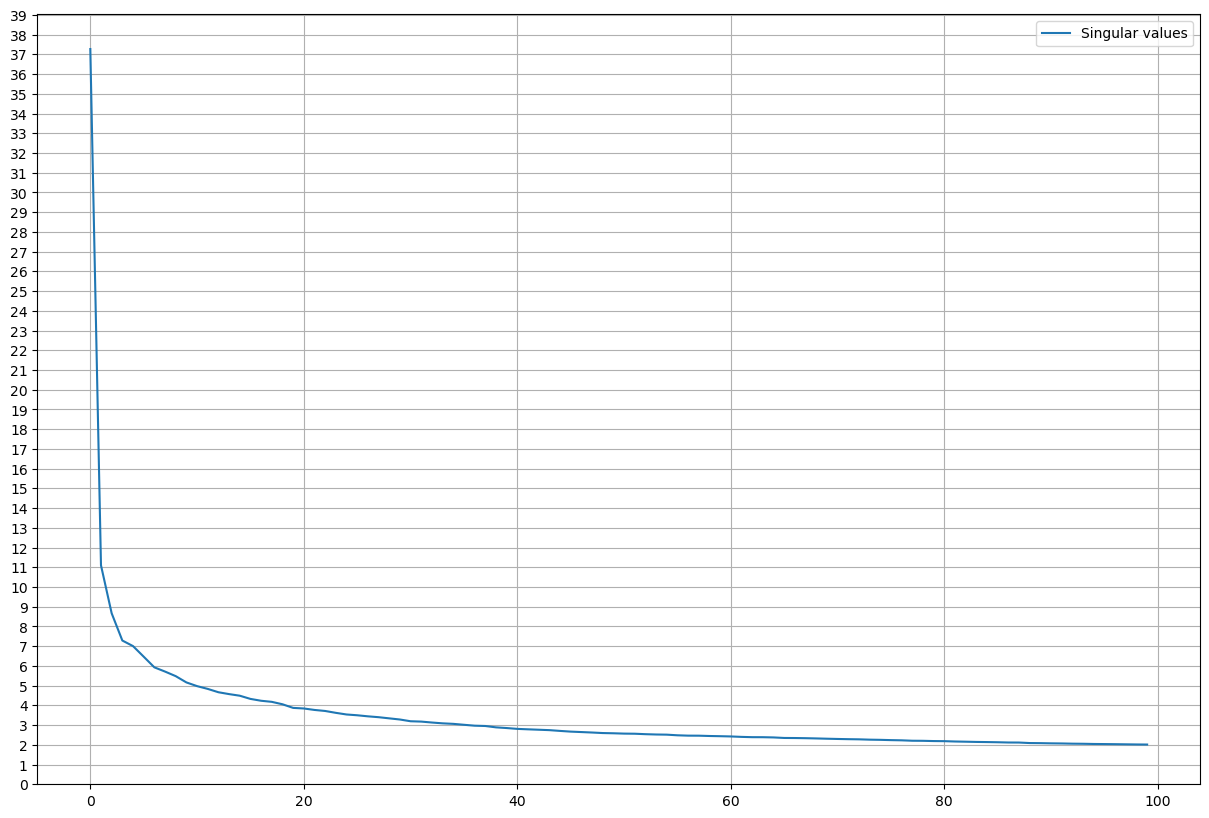

In [43]:
s = np.diag(vect.sigma)

print (vect.sigma)
plt.figure(figsize=(15, 10))
plt.plot(s, label='Singular values')
plt.grid()
plt.legend()
plt.yticks(range(0, 40))
plt.show()



# Thai CBOW Embeddings

In [2]:
# def load_corpus(corp_path):
#     with open(corp_path, 'r',encoding = 'utf-8') as f:
#         corp = list(set(f.read().split('\n')[:-1]))
#     corp = [text.replace('$$$', ' ') for text in corp]
#     corp = [text.split() for text in corp]
#     return corp

def get_vocab(corp_path):
    fin = io.open(corp_path, 'r', encoding='utf-8')
    vocab = set()
    for line in fin:
        for word in line.replace('$$$', ' ').split():
            vocab.add(word)
    return vocab

In [3]:
vocab = get_vocab('Thai_corpus.txt')

In [4]:
len(vocab)

16074599

In [5]:
from gensim.models import Word2Vec
dimension = 100
model = Word2Vec(vector_size=dimension, min_count=1)
model.build_vocab(vocab)
model.save("word2vec_Thai.model")

In [6]:
%%time

with io.open('Thai_corpus.txt', 'r', encoding='utf-8') as file:
    eof = False
    while not eof:
        limit = 1000
        documents = []
        for line in file:
            documents.append(line.split())
            limit -= 1
            if limit == 0:
                break
        else:
            eof = True
        model = Word2Vec.load("word2vec_Thai.model")
        model.build_vocab(documents, update=True)
        model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
        model.save("word2vec_Thai.model")

Wall time: 50min 47s


In [7]:
dictionary = {key : model.wv[key] for key in model.wv.key_to_index}

In [8]:
len(dictionary)

16074140

In [20]:
def save_dictionary(dictionary,shape):
#     for key, value in dictionary.items():
#         dictionary[key] = value.tolist()
    save_name = "Thai_WordVectorDict_CBOW" + str(shape) + ".json"
    with open(save_name, 'w') as f:
        json.dump(dictionary, f)
    

In [32]:
save_dictionary(dictionary,dimension)

In [16]:
model.wv.most_similar('รพรด')

[('พระยาพชยดเบหรูง', 0.9885090589523315),
 ('ผ่ขบ', 0.9884961247444153),
 ('สรรพส้ต่ว็๋', 0.9881777167320251),
 ('วนฮนชใส่ร', 0.9880083799362183),
 ('นึ่นารเค้น', 0.9879629611968994),
 ('ไท๐๑', 0.9878247380256653),
 ('๐ทไขไลไธธนี', 0.9876413345336914),
 ('สะตะติ', 0.9875816106796265),
 ('าทานน', 0.9875491857528687),
 ('แาเวอรแออเารอ', 0.9875255823135376)]

In [22]:
# documents = load_corpus('Thai_corpus.txt')

In [23]:
# len(documents)

In [24]:
# from gensim.models import Word2Vec

In [25]:
# dimension = 100
# model = Word2Vec(sentences=documents, vector_size=dimension, min_count=1)
# model.save("word2vec_Thai.model")

In [26]:
# dictionary = {key : model.wv[key] for key in model.wv.key_to_index}

In [27]:
# dictionary

In [28]:
# len(dictionary)

In [29]:
# model.wv.most_similar('เกม')

In [30]:
# import io
# def save_dictionary(dictionary):
#     for key, value in self.words_embedding_dict.items():
#         dict_[key] = value.tolist()
#     save_name = "Thai_WordVectorDict_CBOW" + str(shape) + ".json"
#     with open(fname, 'w') as f:
#         json.dump(dict_, f)
    
# #     length, dimension = args
# #     fin = io.open(fname, 'w', encoding='utf-8')
# #     fin.write('%d %d\n' % (length, dimension))
# #     for word in dictionary:
# #         fin.write('%s %s\n' % (word, ' '.join(map(str, dictionary[word]))))

In [31]:
# save_dictionary(dictionary)